In [1]:
# Imports
import os

# import methods from FIA python script
from FIA import *

oms.LogConfigHandler().setLogLevel("DEBUG")

## Loading

In [2]:
# set path to your mzML files and workfolder
data_dir = "../../data/example data/exampleA_ecolistrains"
run_dir = "../../runs/fia_explorer"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
fia_df = load_fia_df(data_dir, ".mzXML")

Loading experiments:
Loading names:


## Initial Centroiding

#### TOF Parameters


In [4]:
fia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="TOF",
                                                                                                signal_to_noise=2.0, spacing_difference=1.5,
                                                                                                peak_width=0.0, sn_bin_count=100, nr_iterations=5, sn_win_len=20.0,
                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",
                                                                                                deepcopy=False))

## Data pruning & binning

In [5]:
# Computes mean, media or sum of binned peaks (median needs ~2* more time)
fia_df["bin_experiment"] = fia_df["experiment"].apply(lambda experiment: limit_experiment(experiment, 51, 1699, 2*10**6, statistic="sum", deepcopy=True))

## Summing intensities

In [7]:
fia_df["sum_spectra"] = fia_df["bin_experiment"].apply(lambda experiment: sum_spectra(experiment)) # type: ignore

## Combining

In [11]:
comb_df = pd.DataFrame(columns=["polarity", "comb_experiment"])
for polarity in fia_df["polarity"].unique():
    comb_df.loc[len(comb_df.index)] = [polarity, combine_spectra_experiments(fia_df.loc[fia_df["polarity"] == polarity]["sum_spectra"].to_list())]

## Clustering

In [24]:
clust_df = comb_df.loc[0, "comb_experiment"].get_df(long=True)[["mz", "inty"]]

In [228]:
mz_int_paired = np.stack([clust_df["mz"], clust_df["inty"]], axis=-1)

### Sklearn

In [51]:
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture
import math

In [335]:
methods = []

methods.append(MeanShift(bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=False, n_jobs=None, max_iter=300)
)

methods.append(AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False, random_state=None)
)
methods.append(DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
)

methods.append(HDBSCAN(min_cluster_size=5, min_samples=None, cluster_selection_epsilon=0.0, max_cluster_size=None, metric='euclidean',
                       metric_params=None, alpha=1.0, algorithm='auto', leaf_size=40, n_jobs=None, cluster_selection_method='eom', 
                       allow_single_cluster=False, store_centers=None, copy=False)
                )

methods.append(OPTICS(min_samples=5, max_eps=math.inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05,
                      predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, memory=None, n_jobs=None)
                )
clusters = [method.fit(clust_df.loc[8000:9999]) for method in tqdm(methods)]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


(100.0, 100000000.0)

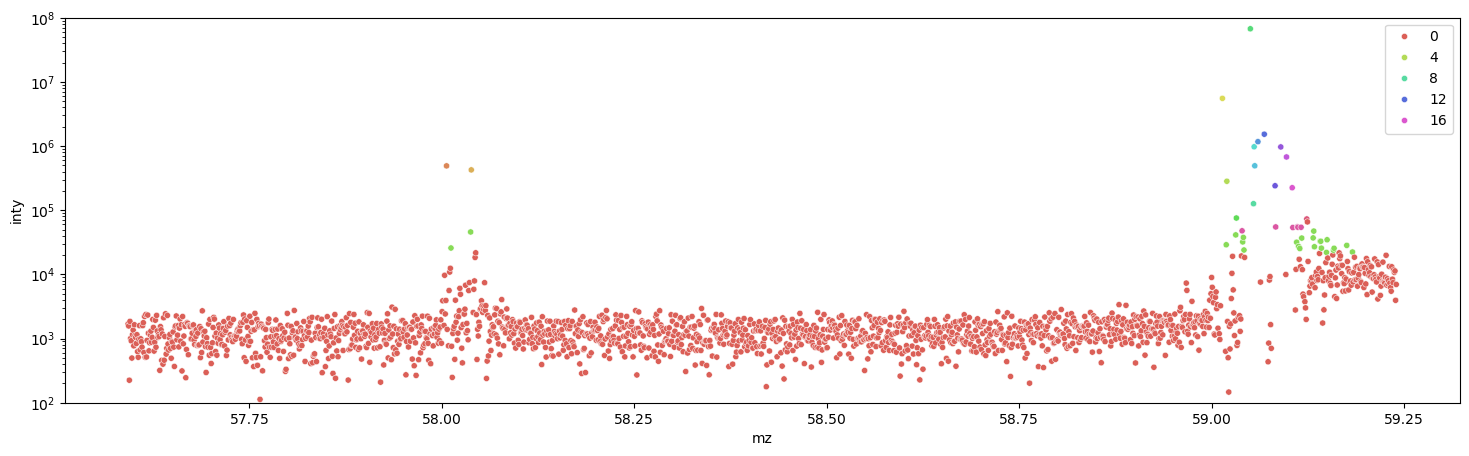

In [343]:
plt.figure(figsize = (18, 5))
cluster = clusters[0]
sns.scatterplot(x=clust_df["mz"][8000:10000], y=clust_df["inty"][8000:10000], hue=cluster.labels_, size=cluster.labels_, sizes=(20, 20), palette="hls")
plt.yscale('log')
plt.ylim([1e2, 1e8])

### Scipy

In [242]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import single, fcluster, complete, complete, dendrogram, linkage

In [382]:
distances = pdist(mz_int_paired[8000:12000], metric="mahalanobis")
tree = linkage(distances, method="complete")
# t = threshold
cluster = fcluster(tree, t=0.4, criterion="distance")

# continous palette: hls, distinct palette: tab10
plt.figure(figsize = (18, 5))
sns.scatterplot(x=clust_df["mz"][8000:12000], y=clust_df["inty"][8000:12000], hue=cluster, size=cluster, sizes=(20, 20), palette="tab10")
plt.yscale('log')
plt.ylim([1e2, 1e8])

In [368]:
np.unique(cluster)

array([-1,  0,  1,  2,  3,  4,  5,  6])

### Own function

In [429]:
## Itertools
from scipy.special import comb
from itertools import combinations
import math
distances = []
for (i, j) in tqdm(combinations(mz_int_paired[8000:12000], 2), total=comb(len(mz_int_paired[8000:12000]), 2)):
    distances.append(  abs(i[0] - j[0])*1e3 * abs(i[1] - j[1])*1e-3 )

100%|██████████| 7998000/7998000.0 [00:12<00:00, 656665.65it/s]


In [430]:
tree = linkage(distances, method="complete")
# t = threshold
cluster = fcluster(tree, t=1e4, criterion="distance")
len(np.unique(cluster))

61

(100.0, 100000000.0)

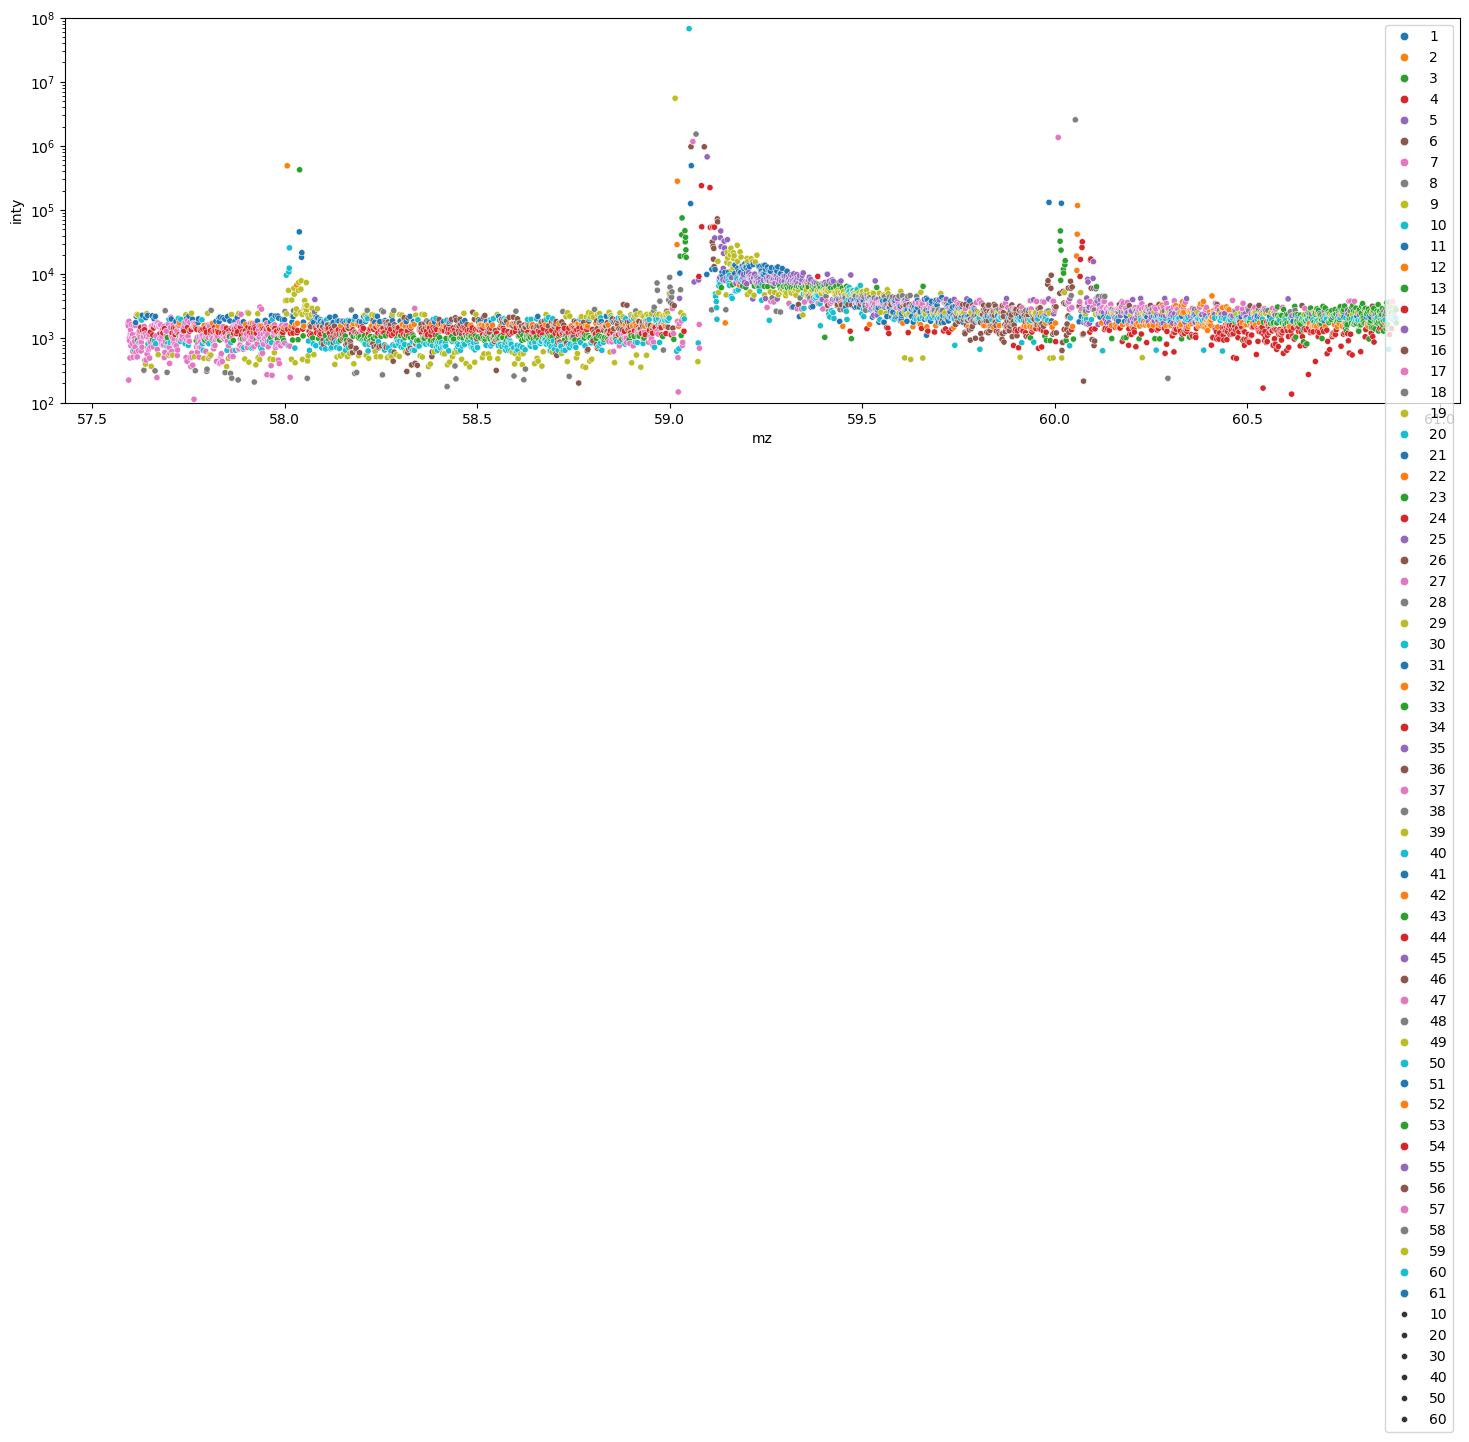

In [431]:
# continous palette: hls, distinct palette: tab10
plt.figure(figsize = (18, 5))
sns.scatterplot(x=clust_df["mz"][8000:12000], y=clust_df["inty"][8000:12000], hue=cluster, size=cluster, sizes=(20, 20), palette="tab10")
plt.yscale('log')
plt.ylim([1e2, 1e8])